#Build Gemma3 270M from Scratch

# Introduction

Let us build a Small Language Model (SLM) from scratch. We will try to keep the parameter size to 50-60 million.

Our goal is to generate creative and coherent text based on the input data.

In [ ]:
!pip install datasets

In [ ]:
pip install -U datasets


In [ ]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

## Step 2: Tokenize the Dataset

In this step, we will do the following:

(1) Tokenize the dataset into tokenIDs.

(2) Create a file called "train.bin" and "validtion.bin" where we will store the tokenIDs from the entire dataset.

(3) We make sure the tokenIDs are stored on a disk, rather than on the RAM for efficient computations.

In [ ]:
!pip install tiktoken
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

## Step 3: Create Input-Output batches for the dataset

In [ ]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Step 4: Define the SLM Model Architecture

In [ ]:
import torch
def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))

    # Generate position indices
    positions = torch.arange(context_length, dtype=dtype)

    # Compute the angles
    angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def apply_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    # Adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    # It's ok to use lower-precision after applying cos and sin rotation
    return x_rotated.to(dtype=x.dtype)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-6, bias=False):
        super().__init__()
        self.eps = eps
        # Gemma3 stores zero-centered weights and uses (1 + weight) during forward
        self.scale = nn.Parameter(torch.zeros(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self, x):
        # Match HF Gemma3: compute norm in float32, then scale by (1 + w)
        input_dtype = x.dtype
        x_f = x.float()
        var = x_f.pow(2).mean(dim=-1, keepdim=True)
        x_norm = x_f * torch.rsqrt(var + self.eps)
        out = x_norm * (1.0 + self.scale.float())

        if self.shift is not None:
            out = out + self.shift.float()

        return out.to(input_dtype)



class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False,
        query_pre_attn_scalar=None, dtype=None,
    ):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        if head_dim is None:
            assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        if qk_norm:
            self.q_norm = RMSNorm(head_dim, eps=1e-6)
            self.k_norm = RMSNorm(head_dim, eps=1e-6)
        else:
            self.q_norm = self.k_norm = None

        if query_pre_attn_scalar is not None:
            self.scaling = (query_pre_attn_scalar) ** -0.5
        else:
            self.scaling = (head_dim) ** -0.5


    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape

        # Apply projections
        queries = self.W_query(x)  # (b, num_tokens, num_heads * head_dim)
        keys = self.W_key(x)       # (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)   # (b, num_tokens, num_kv_groups * head_dim)

        # Reshape
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        # Optional normalization
        if self.q_norm:
            queries = self.q_norm(queries)
        if self.k_norm:
            keys = self.k_norm(keys)

        # Apply RoPE
        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        # Expand K and V to match number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        # Scale queries
        queries = queries * self.scaling

        # Attention
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        return self.out_proj(context)

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.gelu(x_fc1, approximate="tanh") * x_fc2
        return self.fc3(x)


class TransformerBlock(nn.Module):

    def __init__(self, cfg: dict, attn_type: str):
        super().__init__()
        self.attn_type = attn_type

        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],
            head_dim=cfg["head_dim"],
            qk_norm=cfg["qk_norm"],
            query_pre_attn_scalar=cfg["query_pre_attn_scalar"],
            dtype=cfg["dtype"],
        )
        self.ff = FeedForward(cfg)
        self.input_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_attention_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.pre_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)

    def forward(
        self,
        x,
        mask_global,
        mask_local,
        cos_global,
        sin_global,
        cos_local,
        sin_local,
    ):
        # Shortcut connection for attention block
        shortcut = x
        x = self.input_layernorm(x)

        if self.attn_type == "sliding_attention":
            attn_mask = mask_local
            cos = cos_local
            sin = sin_local
        else:
            attn_mask = mask_global
            cos = cos_global
            sin = sin_global

        x_attn = self.att(x, attn_mask, cos, sin)
        x_attn = self.post_attention_layernorm(x_attn)
        x = shortcut + x_attn

        # Shortcut connection for feed forward block
        shortcut = x
        x_ffn = self.pre_feedforward_layernorm(x)
        x_ffn = self.ff(x_ffn)
        x_ffn = self.post_feedforward_layernorm(x_ffn)
        x = shortcut + x_ffn
        return x

class Gemma3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        assert cfg["layer_types"] is not None and len(cfg["layer_types"]) == cfg["n_layers"]

        # Main model parameters
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.blocks = nn.ModuleList([
            TransformerBlock(cfg, attn_type)for attn_type in cfg["layer_types"]
        ])

        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
        self.cfg = cfg

        # Reusuable utilities
        cos_local, sin_local = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_local_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
        cos_global, sin_global = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
        self.register_buffer("cos_local", cos_local, persistent=False)
        self.register_buffer("sin_local", sin_local, persistent=False)
        self.register_buffer("cos_global", cos_global, persistent=False)
        self.register_buffer("sin_global", sin_global, persistent=False)

    def _create_masks(self, seq_len, device):
        ones = torch.ones((seq_len, seq_len), dtype=torch.bool, device=device)

        # mask_global (future is masked: j > i)
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 1 1 1 1 1 1 1
        #     1:  0 0 1 1 1 1 1 1
        #     2:  0 0 0 1 1 1 1 1
        #     3:  0 0 0 0 1 1 1 1
        #     4:  0 0 0 0 0 1 1 1
        #     5:  0 0 0 0 0 0 1 1
        #     6:  0 0 0 0 0 0 0 1
        #     7:  0 0 0 0 0 0 0 0
        mask_global = torch.triu(ones, diagonal=1)

        # far_past (too far back is masked: i - j >= sliding_window)
        # where sliding_window = 4
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 0 0 0 0 0 0 0
        #     1:  0 0 0 0 0 0 0 0
        #     2:  0 0 0 0 0 0 0 0
        #     3:  0 0 0 0 0 0 0 0
        #     4:  1 0 0 0 0 0 0 0
        #     5:  1 1 0 0 0 0 0 0
        #     6:  1 1 1 0 0 0 0 0
        #     7:  1 1 1 1 0 0 0 0
        far_past = torch.triu(ones, diagonal=self.cfg["sliding_window"]).T

        # Local (sliding_window) = future OR far-past
        # mask_local
        #     j:  0 1 2 3 4 5 6 7
        # i
        # 0:      0 1 1 1 1 1 1 1
        # 1:      0 0 1 1 1 1 1 1
        # 2:      0 0 0 1 1 1 1 1
        # 3:      0 0 0 0 1 1 1 1
        # 4:      1 0 0 0 0 1 1 1
        # 5:      1 1 0 0 0 0 1 1
        # 6:      1 1 1 0 0 0 0 1
        # 7:      1 1 1 1 0 0 0 0
        mask_local = mask_global | far_past
        return mask_global, mask_local

    def forward(self, input_ids, targets=None):
        b, seq_len = input_ids.shape
        x = self.tok_emb(input_ids) * (self.cfg["emb_dim"] ** 0.5)
        mask_global, mask_local = self._create_masks(seq_len, x.device)

        for block in self.blocks:
            x = block(
                x,
                mask_global=mask_global,
                mask_local=mask_local,
                cos_global=self.cos_global,
                sin_global=self.sin_global,
                cos_local=self.cos_local,
                sin_local=self.sin_local,
            )

        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
      for _ in range(max_new_tokens):
        ctx_len = self.cfg["context_length"]
        idx_cond = idx if idx.size(1) <= ctx_len else idx[:, -ctx_len:]
        logits, _ = self(idx_cond)  # targets=None by default
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float("-inf")
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
      return idx



In [ ]:
GEMMA3_CONFIG_270M = {
    "vocab_size": 50257,
    "context_length": 32_768,
    "emb_dim": 640,
    "n_heads": 4,
    "n_layers": 18,
    "hidden_dim": 2048,
    "head_dim": 256,
    "qk_norm": True,
    "n_kv_groups": 1,
    "rope_local_base": 10_000.0,
    "rope_base": 1_000_000.0,
    "sliding_window": 512,
      "layer_types": [
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention"
    ],
    "dtype": torch.bfloat16,
    "query_pre_attn_scalar": 256,
}

torch.manual_seed(123)
model = Gemma3Model(GEMMA3_CONFIG_270M)

## Step 5: Define the loss function

In [ ]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [ ]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4
max_iters = 150000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

## Step 7: Define SLM Training Configuration Part 2

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipython-input-2043281014.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


## Step 8: Pre-train the SLM

In [12]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/150000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 9.7023, val loss 9.7089
The current learning rate: 0.00007


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 7.9667, val loss 7.9696
The current learning rate: 0.00010
Epoch 1500: train loss 6.8167, val loss 6.8163
The current learning rate: 0.00010
Epoch 2000: train loss 5.8444, val loss 5.8524
The current learning rate: 0.00010
Epoch 2500: train loss 5.1325, val loss 5.1262
The current learning rate: 0.00010
Epoch 3000: train loss 4.6965, val loss 4.6994
The current learning rate: 0.00010
Epoch 3500: train loss 4.3937, val loss 4.3979
The current learning rate: 0.00010
Epoch 4000: train loss 4.1975, val loss 4.1969
The current learning rate: 0.00010
Epoch 4500: train loss 4.0489, val loss 4.0432
The current learning rate: 0.00010
Epoch 5000: train loss 3.9225, val loss 3.9234
The current learning rate: 0.00010
Epoch 5500: train loss 3.8216, val loss 3.8208
The current learning rate: 0.00010
Epoch 6000: train loss 3.7346, val loss 3.7394
The current learning rate: 0.00010
Epoch 6500: train loss 3.6620, val loss 3.6568
The current learning rate: 0.00010
Epoch 7000: trai

## Step 9: Plot the SLM Loss Function

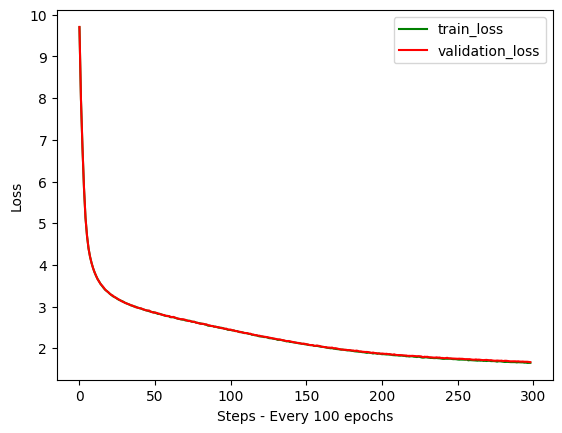

In [13]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [14]:
#Load the model
model = Gemma3Model(GEMMA3_CONFIG_270M)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [15]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. This pumpkin was very special. It was a big special pumpkin because it was real. Everyone was so amazed by the green color!

One day, a hurricane came to the field and it was strong. The wind was so strong that it broke the field and scared away the whole trees. All the pumpkins were safe.

They all wanted to play near the patch, so they stepped closer. The goodies inside were a lot of fruit and fruit. They played games and laughed with each other.

But then they heard a loud noise. It was the sound of war - a dangerous animal and it was coming from behind the field. They sat in their spot and watched the birds move in the sky.

The powerful animal and the other animals in the field were scared of the dangerous wild animal too. After a while, the scary animal removed the other animals and made their homes all ok. The harsh animal was very happy and they had become friends. Now the field could


In [16]:
sentence = "A little girl went to the woods"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

A little girl went to the woods alone. She looked around and the animals had been playing a game. Then she said, "I want to tell you a secret."

The little girl was surprised at the little animals' idea. She quickly began to tell a funny joke. After a few moments, the animal revealed a perfect little bird. The little girl smiled. She said, "Very good!"

The little girl smiled too. She waved goodbye to the animals, happy with her creation. She said, "We have a new friend!"

The animal replied, "Now is this place!"The sun shone brightly and the birds sang and pecked at the ground. Jill was delighted to see her pet, Pippy, running around in the woods. boardinginnieorting made her happy and powerful.

Suddenly she heard a noise. Jill looked up and discovered a big grey rabbit. It had one beautifully gave her an hugs. Jill was so happy to see the rabbit again.

She smiled


In [17]:
sentence = "The footballer was"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

The footballer was pleased with the idea one day. From then on, the family decided to accept the idea we created together and value it more than ever.Tommy was a 3 year old boy who loved playing with his toys. He kept playing every day in his garden. One day he decided to take a walk and he saw a helpless animal walking through the bridge. He wanted to help it, but he knew he had to measure it!

He ran to the bridge and peered in the water. He saw a frog. The frog was helpless and couldn't jump high enough. Benny knew he had to help. He bent down, grabbed the frog in his hands and dipped it into the water. With a soft heave, the little frog was able to out its improved log.

From that day on, Benny was able to make sure that the hippo was deserved and taken care of. The moral of the story is that when you help others, everyone can accomplish anything.One day
